### Neuroevolution:

- Allgemein:
    - Bei jeder Mutation gibt es eine mutation rate (wie viele Parameter werden verändert) und mutation strength (wie stark werden die ausgewählten parameter mutiert werden)
    - Mutationen basieren auf Gaussian noise
    - Die agents, die für die nächste Generation mutiert werden sollen, werden mithilfe von fitness proportional selection (roulette wheel selection) ausgewählt. Vorher wird die fitness allerdings normalisiert und softmax angewandt (Temperatur ist Hyperparameter)
    - Elitismus: Die besten n (Hyperparameter) Agents pro Generation werden unverändert direkt in die nächste Generation übernommen
    - Jede Generation hat exakt viele Agenten
    - Die nächste Generation basiert immer auf den Eliten + mutierten Nachkommen von Selektierten (Eliten machen bei der roulette wheel selection mit)
    - Agent bricht nach ersten Tod ab bzw nach max steps ab
    - Es wird der standard reward von super mario gym benutzt

- Klassenaufteilung:

    - NeuroevolutionNet:
        - Konfigurierbares neuronales Netz bestehend aus CNN + MLP.
        - Flexible Layer-Definition via cnn_config / mlp_config
        - Gewichtsinitialisierung mit Xavier init
        - Mutiert mit zufälligen hinzufügen von gaussian noise

    - NeuroevolutionAgent:
        - Führt Preprocessing des Beobachtungsbildes durch (Graustufen, Resize, Normalisierung).
        - Wählt Aktion per argmax(logits) aus dem Netzoutput.
        - Bewertet Episode berechnet Gesamtfitness
        - Erkennt eigenen Tod (erster Tod ist permanent, nur 1 von 3 Leben wird genutzt)

    - NeuroevolutionTrainer:
        - Führt den gesamten evolutionären Trainingsprozess durch
        - Startpopulation erzeugen (Kopien des Basisnetzes).
        - Agenten evaluieren und selektieren (roulette wheel selection ).
        - Neue Generation erzeugen (inkl. Elitismus).
        - Speichert Fitnessmetriken (best/avg/min).
        - Zeichnet bestes Modell im Video auf
        - Plot der Fitnessverläufe (matplotlib), Speicherung als PNG.
        - Speichert bestes model und kann model laden


#### ToDo:
- Hyperparameter suche (gridsearch?)
- Hilfsplott mit wichtigen Informationen zum aktuellen training: Anzahl in Prozent wie viele Agenten aus Mutationen von Eliteagenten in aktueller Generation enstanden sind
- Dynamische Mutation (z.B: erhöhe Mutationsstärke bei Stillstand)
- Gespeicherte models nochmal finetunen, testen, überüfen ob die wirklich konstant gute Ergebnisse haben

#### Nice to have:
- Verbesserung der GPU Auslastung (Hat sich als schwierig herausgestellt, im Moment ist cpu-only schneller!)
- Frame skipping um performance zu erhöhen (Auch schwierig hauptlast ist nicht die entscheidung des agenten sondern die laufende mario umgebung)
- Percentage clipping für die eliteagents?

In [ ]:
import torch
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT, SIMPLE_MOVEMENT, RIGHT_ONLY
%config InlineBackend.figure_format = 'retina'

DEVICE = "cpu"  #torch.device("cuda" if torch.cuda.is_available() else "cpu")

CNN_CONFIG = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]

MLP_CONFIG = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(RIGHT_ONLY)
]

model = NeuroevolutionNet(
    input_channels=1,
    num_actions=len(RIGHT_ONLY),
    cnn_config=CNN_CONFIG,
    mlp_config=MLP_CONFIG
)

trainer = NeuroevolutionTrainer(
    base_model=model,
    env_name='SuperMarioBros-1-1-v0',
    action_set=RIGHT_ONLY,
    device=DEVICE,
    directory="../runs/neuroevolution",
    generations=3,
    population_size=2,
    max_steps_per_episode=200,
    mutation_rate_range=(0.02, 0.2),
    mutation_strength_range=(0.01, 0.1),
    roulette_wheel_selection_temperature=1.1,
    elitism=1
)

#trainer.run()
#trainer.record_best_agent()
#trainer.save_metrics()
#trainer.save_best_model()

# Random Hyperparameter Search 1

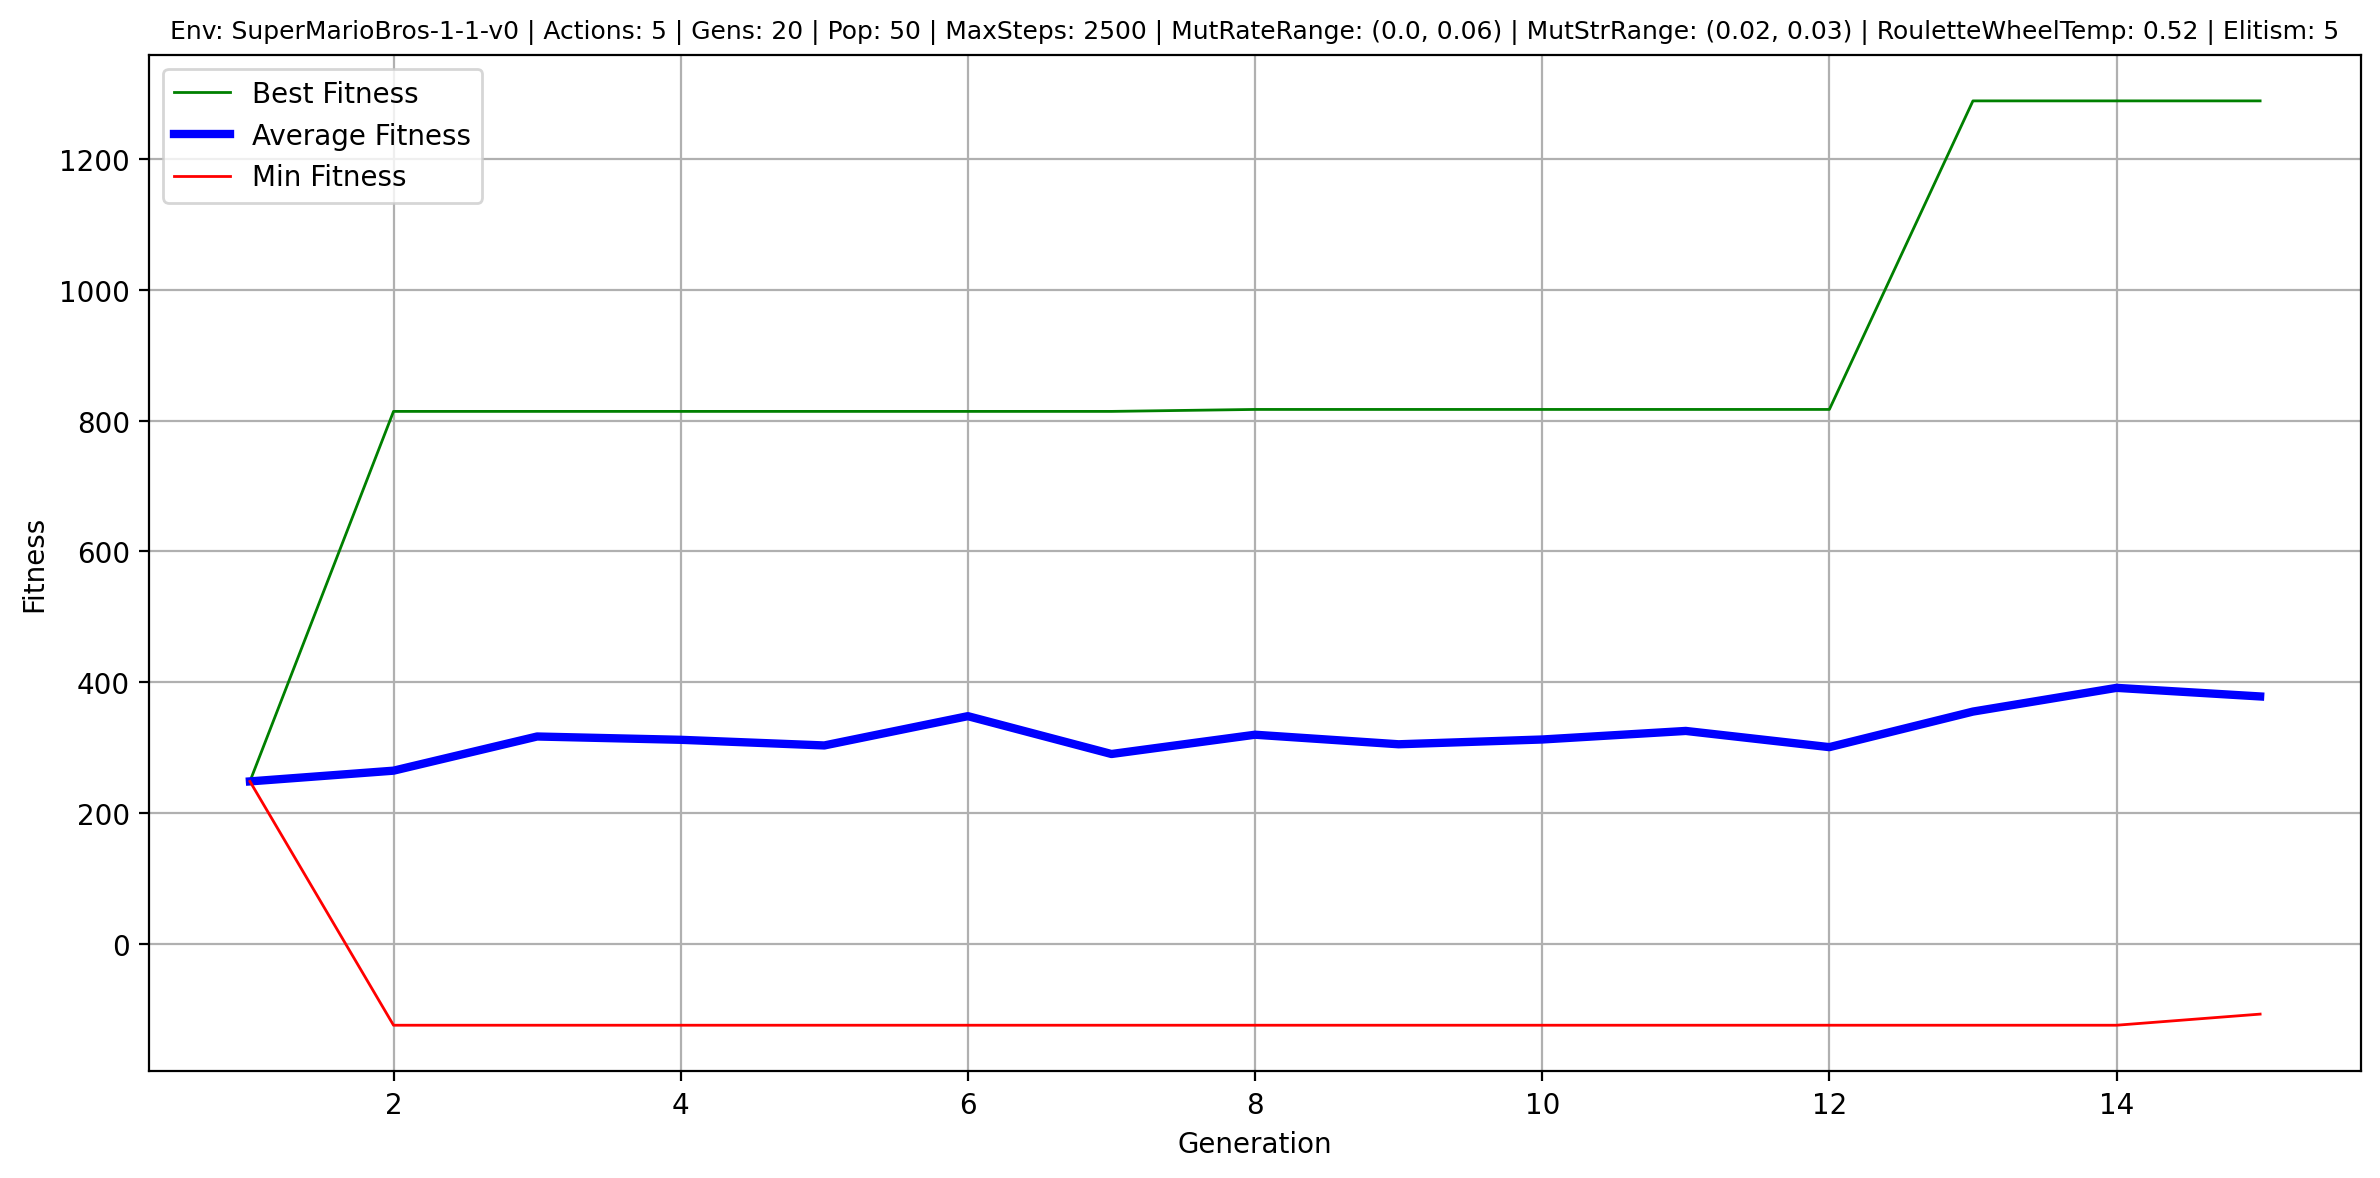

In [ ]:
import random
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import RIGHT_ONLY
%config InlineBackend.figure_format = 'retina'

# Constants
CNN_CONFIG = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]
MLP_CONFIG = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(RIGHT_ONLY)
]
ENV_NAME = 'SuperMarioBros-1-1-v0'
ACTION_SET = RIGHT_ONLY
DEVICE = "cpu"
DIRECTORY = "../runs/neuroevolution/random_hyperparameter_search_1"
GENERATIONS = 20
POPULATION_SIZE = 50
MAX_STEPS_PER_EPISODE = 2500

# Hyperparameter search ranges
MUTATION_RATE_SELECTION_INTERVAL = (0.00, 0.3)

MUTATION_STRENGTH_SELECTION_INTERVAL = (0.00, 0.2)

ROULETTE_TEMP_MIN = 0.5
ROULETTE_TEMP_MAX = 2.0

ELITISM_OPTIONS = [0, 1, 2, 3, 4, 5]

while True:
    model = NeuroevolutionNet(
        input_channels=1,
        num_actions=len(RIGHT_ONLY),
        cnn_config=CNN_CONFIG,
        mlp_config=MLP_CONFIG
    )

    r1 = round(random.uniform(*MUTATION_RATE_SELECTION_INTERVAL), 2)
    r2 = round(random.uniform(*MUTATION_RATE_SELECTION_INTERVAL), 2)
    mutation_rate_range = tuple(sorted((r1, r2)))

    r1 = round(random.uniform(*MUTATION_STRENGTH_SELECTION_INTERVAL), 2)
    r2 = round(random.uniform(*MUTATION_STRENGTH_SELECTION_INTERVAL), 2)
    mutation_strength_range = tuple(sorted((r1, r2)))

    roulette_wheel_selection_temperature = round(random.uniform(ROULETTE_TEMP_MIN, ROULETTE_TEMP_MAX), 2)
    elitism = random.choice(ELITISM_OPTIONS)

    trainer = NeuroevolutionTrainer(
        base_model=model,
        env_name=ENV_NAME,
        action_set=ACTION_SET,
        device=DEVICE,
        directory=DIRECTORY,
        generations=GENERATIONS,
        population_size=POPULATION_SIZE,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        mutation_rate_range=mutation_rate_range,
        mutation_strength_range=mutation_strength_range,
        roulette_wheel_selection_temperature=roulette_wheel_selection_temperature,
        elitism=elitism
    )
    trainer.run()
    trainer.record_best_agent()
    trainer.save_metrics()
    trainer.save_best_model()